In [1]:
import scipy.io as sio
import numpy as np

In [2]:
def mat2dict(filename):
    """Converts MoVi mat files to a python nested dictionary.
    This makes a cleaner representation compared to sio.loadmat
    Arguments:
        filename {str} -- The path pointing to the .mat file which contains
        MoVi style mat structs
    Returns:
        dict -- A nested dictionary similar to the MoVi style MATLAB struct
    """
    # Reading MATLAB file
    data = sio.loadmat(filename, struct_as_record=False, squeeze_me=True)

    # Converting mat-objects to a dictionary
    for key in data:
        if key != "__header__" and key != "__global__" and key != "__version__":
            if isinstance(data[key], sio.matlab.mio5_params.mat_struct):
                data_out = matobj2dict(data[key])
    return data_out


def matobj2dict(matobj):
    """A recursive function which converts nested mat object
    to a nested python dictionaries

    Arguments:
        matobj {sio.matlab.mio5_params.mat_struct} -- nested mat object

    Returns:
        dict -- a nested dictionary
    """
    ndict = {}
    for fieldname in matobj._fieldnames:
        attr = matobj.__dict__[fieldname]
        if isinstance(attr, sio.matlab.mio5_params.mat_struct):
            ndict[fieldname] = matobj2dict(attr)
        elif isinstance(attr, np.ndarray) and fieldname == "move":
            for ind, val in np.ndenumerate(attr):
                ndict[
                    fieldname
                    + str(ind).replace(",", "").replace(")", "").replace("(", "_")
                ] = matobj2dict(val)
        elif fieldname == "skel":
            tree = []
            for ind in range(len(attr)):
                tree.append(matobj2dict(attr[ind]))
            ndict[fieldname] = tree
        else:
            ndict[fieldname] = attr
    return ndict



In [3]:
data = mat2dict('../data/AMASS/F_amass_Subject_1.mat')
len(data['move_0']['jointsLocation_amass'])

581

In [4]:
joints = data['move_0']['jointsLocation_amass']
joints, joints.shape

(array([[[373.28643049, 256.40073867, 955.47778345],
         [353.75470365, 317.86515453, 870.13708985],
         [365.54407025, 191.33526721, 861.75640858],
         ...,
         [429.23064972,   1.58622005, 856.33614845],
         [437.15028907,  22.95146027, 833.58482457],
         [447.49312545,  32.03620651, 809.49361808]],
 
        [[373.3180504 , 256.39192671, 955.4722096 ],
         [353.89069129, 317.74728843, 870.02929031],
         [365.95113982, 191.23400845, 861.78480937],
         ...,
         [429.87706174,   1.62017443, 856.28778591],
         [437.81494011,  23.0745832 , 833.62691208],
         [448.18567146,  32.2550694 , 809.58403751]],
 
        [[372.84393154, 256.30762238, 955.53079525],
         [353.42551314, 317.66275313, 870.08567431],
         [365.47417485, 191.14811715, 861.84471378],
         ...,
         [429.38458465,   1.55661251, 856.32733533],
         [437.31873773,  23.01660921, 833.67045501],
         [447.68860482,  32.20348801, 809.62964424]

In [5]:
# markers(1:4:end,:,:);
markers = joints[0::4,:,:]
markers.shape

(146, 52, 3)

In [6]:
# Validation
import scipy.io as sio
markers_matlab = sio.loadmat('/home/ugnelis/GIT/MoVi/chark/MoVi-Toolbox/MoCap/Markers.mat', simplify_cells=True)['Markers']
markers_matlab.shape

(146, 52, 3)

In [7]:
# For some reason number after comma don't match
markers[0, 3, 0], markers_matlab[0, 3, 0]

(328.662936338117, 328.6629512392782)

In [8]:
import cv2
import matplotlib
from matplotlib import pyplot as plt

cap = cv2.VideoCapture('../data/PG1/F_PG1_Subject_1_L1.avi')
cap.isOpened()
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(length)
fps = cap.get(cv2.CAP_PROP_FPS)
print(fps)
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
print(width)
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
print(height)

146
30.0
800.0
600.0


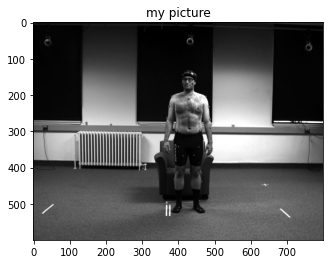

In [9]:
total_frames = cap.get(0)
ret, frame = cap.read()

plt.imshow(frame)
plt.title('my picture')
plt.show()

In [10]:
camera_data = np.load('../data/Calib/cameraParams_PG1.npz')
for key in camera_data.files:
    print(key)

IntrinsicMatrix
RadialDistortion


In [11]:
intrinsic_matrix = camera_data['IntrinsicMatrix']
# intrinsic_matrix = np.rot90(np.fliplr(intrinsic_matrix))
print(intrinsic_matrix)

# fx = intrinsic_matrix[0][0]
# fy = intrinsic_matrix[1][1]
# cx = intrinsic_matrix[2][0]
# cy = intrinsic_matrix[2][1]

[[979.17889011   0.           0.        ]
 [  0.         978.10179305   0.        ]
 [408.0273103  291.16967878   1.        ]]


In [12]:
radial_distortion = camera_data['RadialDistortion']
radial_distortion

array([-0.18236467,  0.18388686])

In [13]:
extrinsics_data = np.load('../data/Calib/Extrinsics_PG1.npz')
for key in extrinsics_data.files:
    print(key)

rotation_matrix = extrinsics_data['rotationMatrix']
translation_vector = extrinsics_data['translationVector']
rotation_matrix, translation_vector

rotationMatrix
translationVector


(array([[ 0.0305191 ,  0.06318672, -0.99753497],
        [ 0.99942183,  0.01303452,  0.03140247],
        [ 0.01498661, -0.9979166 , -0.06275239]]),
 array([-177.23154422, 1030.55751095, 4999.31781498]))

https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html

In [14]:
# output should be 430.43858566, 313.3995152
def world_to_image(rotation_matrix, translation_vector, intrinsic_matrix, world_points):
    translation_vector_expand = np.expand_dims(translation_vector, axis=0)
    rot_tran_matrix = np.concatenate((rotation_matrix, translation_vector_expand), axis=0)
    camera_matrix = np.dot(rot_tran_matrix, intrinsic_matrix)
    image_points = np.zeros((world_points.shape[0], 2), dtype=int)

    for idx, val in enumerate(world_points): 
        temp_matrix = np.append(val, 1)
        result = np.dot(temp_matrix, camera_matrix)
        u = result[0] / result[2]
        v = result[1] / result[2]
        image_points[idx, :] = [u, v]

    return image_points

# def worldToVideo(mdData, cameraParams, rotationMatrix, translationVector):
def world_to_video(mocap_data, rotation_matrix, translation_vector, intrinsic_matrix):
    markers = mocap_data[0::4, :, :]
    image_points = np.full((markers.shape[0], markers.shape[1], 2), 0, dtype=int)
    for i in range(0, markers.shape[1]):
        world_points = np.squeeze(markers[:, i, :])
        temp_image_points = world_to_image(rotation_matrix, translation_vector, intrinsic_matrix, world_points)
        image_points[:, i] = temp_image_points
    
    return image_points


points = world_to_video(joints, rotation_matrix, translation_vector, intrinsic_matrix)

In [15]:
# Validation
import scipy.io as sio
worldToImageVar = sio.loadmat('/home/ugnelis/GIT/MoVi/chark/MoVi-Toolbox/MoCap/worldToImageVar.mat', simplify_cells=True)['worldToImageVar']
worldToImageVar.shape

(146, 2)

In [16]:
# Validation
import scipy.io as sio
imagePoints = sio.loadmat('/home/ugnelis/GIT/MoVi/chark/MoVi-Toolbox/MoCap/imagePoints_after.mat', simplify_cells=True)['imagePoints']
imagePoints.shape

(146, 52, 2)

In [17]:
empty_frame = np.full(frame.shape, 255, dtype = "uint8")
new_frame = cv2.circle(frame, (points[0, 10, 0], points[0, 10, 1]), radius=0, color=(124, 252, 0), thickness=20)

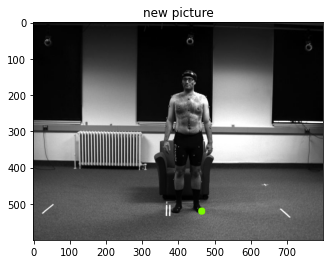

In [18]:
plt.imshow(new_frame)
plt.title('new picture')
plt.show()

In [ ]:
int(worldToImageVar[0, 0]), int(worldToImageVar[0, 1])

In [ ]:
width = 800
height = 600
fps = 30
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video = cv2.VideoWriter('output.avi', fourcc, fps, (width, height))

cap = cv2.VideoCapture('../data/PG1/F_PG1_Subject_1_L1.avi')
total_frames = cap.get(0)
cap.set(1, 0)

current_frame_num = 0
while cap.isOpened():
    ret, frame = cap.read()
    if ret == True:
        frame_points = points[current_frame_num]
        for idx, val in enumerate(frame_points):
            frame = cv2.circle(frame, (val[0], val[1]), radius=2, color=(124, 252, 0), lineType=cv2.LINE_AA, thickness=-1)
        video.write(frame)
        current_frame_num = current_frame_num + 1
    else:
        break

cap.release()
video.release()

(430, 313)

In [44]:
width = 800
height = 600
fps = 30
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video = cv2.VideoWriter('output.avi', fourcc, fps, (width, height))

cap = cv2.VideoCapture('../data/PG1/F_PG1_Subject_1_L1.avi')
total_frames = cap.get(0)
cap.set(1, 0)

current_frame_num = 0
while cap.isOpened():
    ret, frame = cap.read()
    if ret == True:
        frame_points = points[current_frame_num]
        for idx, val in enumerate(frame_points):
            frame = cv2.circle(frame, (val[0], val[1]), radius=2, color=(124, 252, 0), lineType=cv2.LINE_AA, thickness=-1)
        video.write(frame)
        current_frame_num = current_frame_num + 1
    else:
        break

cap.release()
video.release()